In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import pandas as pd
import numpy as np
import pickle

from model import NeuralNetwork , NeuralNetwork_Adjustable, TrackNetwork, NeuralNetworkHigh
from utils import count_parameters, plot_metrics

import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.classification import BinaryAccuracy, AUROC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics

from time import time

import gc, os

In [3]:

################################################################ device settings ################################################################
dtype  = 'np.float32'
device = "mps" if torch.backends.mps.is_available() else "cpu"     
device = torch.device(device)
print(f"Using device: {device}")
################################################################ Data Preparation ################################################################
sample_size  = int(1e+6)
print('Preparing data...')
start = time()
       
df  = pd.read_hdf(f'/Users/asugu/Desktop/b_tag_DNN/data/all_data_{sample_size}.hdf5', key='data', dtype=dtype)   
df = df.astype(np.float32)   

Using device: mps
Preparing data...


In [4]:
df['pt_cosh']=df['jet_pt']*np.cosh(df['jet_eta'])     # |p|
col_names = df.keys()
target_col_name = "jet_flavor"
input_col_names = [col_name for col_name in col_names if col_name != target_col_name]
df.replace({"inf": 0, "-inf": 0}, inplace=True)

df = df[(np.abs(df-df.mean()) <= 10*df.std()).all(axis=1)]

orj_inputs = df[input_col_names]
labels = df[target_col_name] 
labels = (labels==5).astype(int) 


In [5]:
# change this part

column_names = []

names = ["jet_pt", "jet_eta","pt_cosh"]

for name in names:
        column_names.append(name)
# high level trck variables
names_tr = ["trck_2_d0_sig", "trck_3_d0_sig",
            "trck_2_z0_sig", "trck_3_z0_sig",
            "n_trcks_over_d0_thrsld", "jet_prob", "jet_width_eta", 
            "jet_width_phi"]

prefix_tr = "hl_trck_var_"
for name in names_tr:
    column_names.append(prefix_tr + name)


names_vr = ["vtx_sig", "n_secondary_vertices", "n_secondary_vtx_trcks",
            "delta_r_vtx", "vtx_mass", "vtx_energy_frac"]

prefix_vr = "hl_vtx_var_"

for name in names_vr:
    column_names.append(prefix_vr + name)

track_input_names = [col_name for col_name in col_names if col_name not in column_names+["jet_flavor"]]
high_input_names = [col_name for col_name in col_names if col_name in column_names]
inputs = orj_inputs[high_input_names]
track_inputs = orj_inputs[track_input_names]

print(inputs.shape[1])

del df
gc.collect()

17


0

In [6]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(inputs, labels, stratify = labels, test_size = 0.2, shuffle = True, random_state = 42)

del inputs
gc.collect()


scaler = StandardScaler()
train_inputs = scaler.fit_transform(train_inputs)
val_inputs  = scaler.transform(val_inputs)

pca_decomposition = PCA()
train_inputs = pca_decomposition.fit_transform(train_inputs)
val_inputs   = pca_decomposition.transform(val_inputs)

train_inputs = torch.tensor(train_inputs,  dtype=torch.float32, device = 'cpu')
train_labels = torch.tensor(train_labels.to_numpy(),  dtype=torch.float32, device = 'cpu').reshape(-1, 1)

val_inputs  = torch.tensor(val_inputs,  dtype=torch.float32, device = device)
val_labels  = torch.tensor(val_labels.to_numpy(),  dtype=torch.float32, device = device).reshape(-1, 1)

batchsize   = int(len(train_inputs)/10)
trainloader = DataLoader(list(zip(train_inputs, train_labels)), batch_size = batchsize , drop_last=True )

finish = time()

print(f'Data preparation has taken {finish-start:.1f} seconds for {len(train_inputs)+len(val_inputs)} rows.')

Data preparation has taken 12.9 seconds for 930889 rows.


In [13]:
######################################################### Model constrcution #########################################################

print('Building model...', end='\r')
input_size  = len(column_names)  # for high level
output_size = 1

model = NeuralNetworkHigh(input_size, output_size, nnode=32)
count_parameters(model)

##################################################### Loss and Optimizer Settings #####################################################

def learning_rate(i_epoch, initial_lr = 0.01, decay_rate = 0.01):
    return initial_lr * (1-decay_rate)**i_epoch

criterion = nn.BCELoss()       
optimizer = torch.optim.RMSprop(model.parameters())

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
|  layer1.weight  |    544     |
|   layer1.bias   |     32     |
|  layer2.weight  |    1024    |
|   layer2.bias   |     32     |
|  layer3.weight  |    1024    |
|   layer3.bias   |     32     |
|  layer4.weight  |    1024    |
|   layer4.bias   |     32     |
| layerfin.weight |     32     |
|  layerfin.bias  |     1      |
+-----------------+------------+
Total Trainable Params: 3777


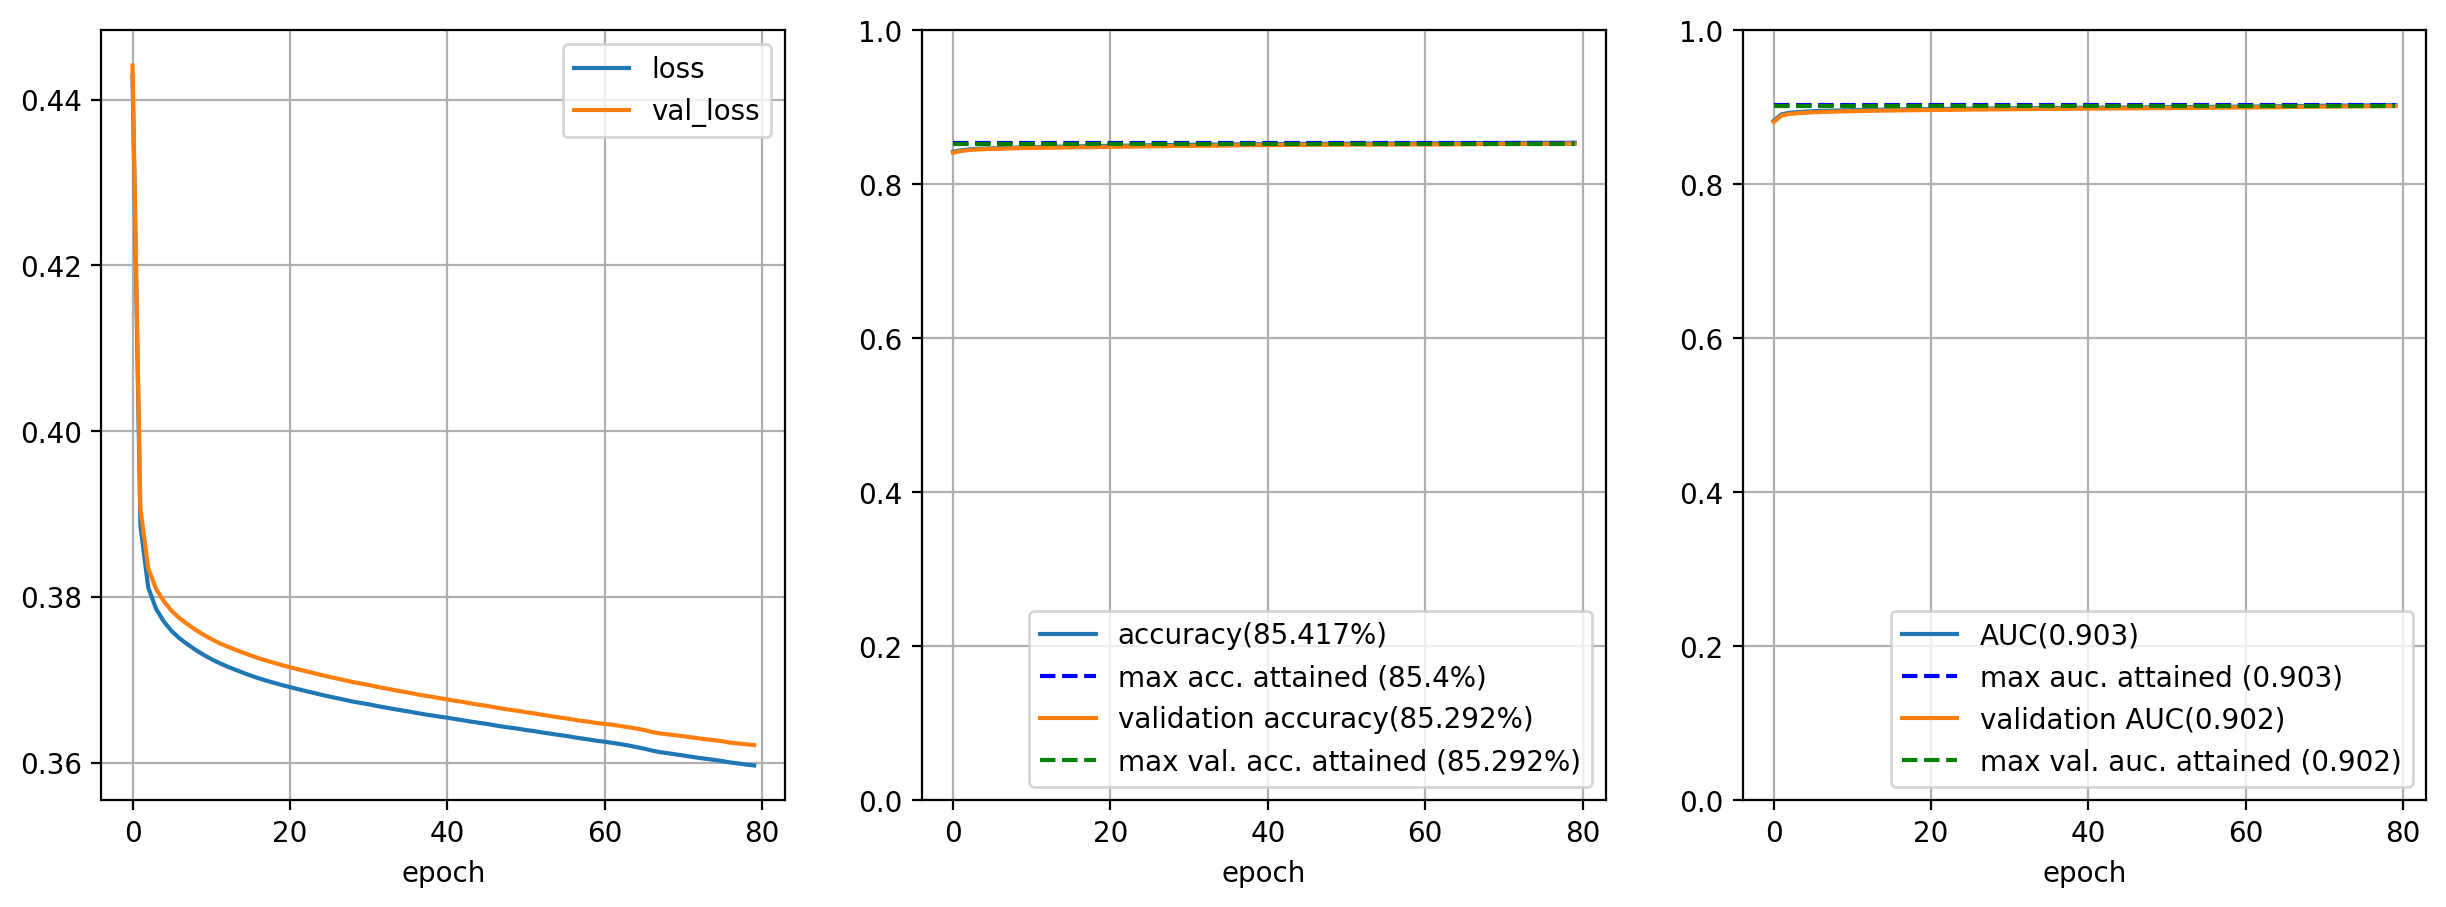

Training: Epoch [80/80] --- Loss: 0.3597 --- Accuracy: 0.8542 --- AUC: 0.903
Test    : Epoch [80/80] --- Loss: 0.3621 --- Accuracy: 0.8529 --- AUC: 0.902


In [14]:
#################################################### High Level Training #############################################################

n_epochs  = 80

train_losses = []
train_accuracies = []
train_aucs = []
val_losses = []
val_accuracies = []
val_aucs = []

for i_epoch in range(n_epochs):
    
    optimizer.param_groups[0]['lr'] = learning_rate(i_epoch, initial_lr=0.001, decay_rate=0.001) 
    lr = optimizer.param_groups[0]['lr']
    print(f'learning rate was set to {lr:.5f}.')
    
    train_loop = trainloader     
    
    ############################################################ Batch Training ############################################################
    model.to(device)   
    model.train() 
    for i_batch, (train_input, train_label) in enumerate(train_loop):
        
        train_input = train_input.float().to(device)
        train_label = train_label.reshape(-1,1).float().to(device)
            
        optimizer.zero_grad()
        
        train_pred = model(train_input, key = 'train')
         
        loss = criterion(train_pred, train_label)
        
        if not torch.isnan(loss): 
            loss.backward()
            optimizer.step()
        
    #########################################################  Evaluate metrics #########################################################
    
    print('Evaluating metrics...', end='\r')
    
    acc_metric = BinaryAccuracy()
    auc_metric = AUROC(task="binary")
    
    model.eval()
        
    with torch.no_grad():
        
        model.to('cpu')
        val_inputs = val_inputs.cpu()
        val_labels = val_labels.cpu()
        
        train_preds = model(train_inputs, key = 'train')
        val_preds  = model(val_inputs, key = 'train')
        
        train_loss = criterion(train_preds, train_labels)
        val_loss  = criterion(val_preds, val_labels)
        
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
        train_accuracy = acc_metric(train_preds, train_labels)
        val_accuracy = acc_metric(val_preds, val_labels)
        
        train_accuracies.append(train_accuracy.item())
        val_accuracies.append(val_accuracy.item())
        
        train_auc = auc_metric(train_preds, train_labels)
        val_auc = auc_metric(val_preds, val_labels)
        
        train_aucs.append(train_auc.item())
        val_aucs.append(val_auc.item())
    
    plot_metrics(np.arange(i_epoch+1), train_losses, val_losses, train_accuracies, val_accuracies, train_aucs, val_aucs)
        
     
    print('Evaluating metrics finished!', end='\r')  
    print(f'Training: Epoch [{i_epoch+1}/{n_epochs}] --- Loss: {train_losses[-1]:.4f} --- Accuracy: {train_accuracies[-1]:.4f} --- AUC: {train_aucs[-1]:.3f}\nTest    : Epoch [{i_epoch+1}/{n_epochs}] --- Loss: {val_losses[-1]:.4f} --- Accuracy: {val_accuracies[-1]:.4f} --- AUC: {val_aucs[-1]:.3f}\n', end='\r')


In [15]:
######################################################## Track Pre-Processing #############################################################
start = time()
train_inputs, val_inputs, train_labels, val_labels = train_test_split(track_inputs, labels, stratify = labels, test_size = 0.2, shuffle = True, random_state = 42)

del track_inputs
gc.collect()


scaler = StandardScaler()
train_inputs = scaler.fit_transform(train_inputs)
val_inputs  = scaler.transform(val_inputs)

pca_decomposition = PCA()
train_inputs = pca_decomposition.fit_transform(train_inputs)
val_inputs   = pca_decomposition.transform(val_inputs)

train_inputs = torch.tensor(train_inputs,  dtype=torch.float32, device = 'cpu')#.float().unsqueeze(0).reshape(-1, 1, input_size)
train_labels = torch.tensor(train_labels.to_numpy(),  dtype=torch.float32, device = 'cpu').reshape(-1, 1)

val_inputs  = torch.tensor(val_inputs,  dtype=torch.float32, device = device)#.float().unsqueeze(0).reshape(-1, 1, input_size)
val_labels  = torch.tensor(val_labels.to_numpy(),  dtype=torch.float32, device = device).reshape(-1, 1)

batchsize   = int(len(train_inputs)/10)
trainloader = DataLoader(list(zip(train_inputs, train_labels)), batch_size = batchsize , drop_last=True )

finish = time()
print(batchsize)
print(f'Data preparation has taken {finish-start:.1f} seconds for {len(train_inputs)+len(val_inputs)} rows.')
      


74471
Data preparation has taken 16.4 seconds for 930889 rows.


In [20]:
print('Building model...', end='\r')
input_size  = 420    # 15 x 28
output_size = 1

model_track = TrackNetwork()
count_parameters(model_track)

##################################################### Loss and Optimizer Settings #####################################################

def learning_rate(i_epoch, initial_lr = 0.01, decay_rate = 0.01):
    return initial_lr * (1-decay_rate)**i_epoch

criterion = nn.BCELoss()       
optimizer = torch.optim.RMSprop(model_track.parameters())

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    896     |
|  conv1.bias  |     32     |
|  fc1.weight  |   15360    |
|   fc1.bias   |     32     |
|  fc2.weight  |    1024    |
|   fc2.bias   |     32     |
|  fc3.weight  |     32     |
|   fc3.bias   |     1      |
+--------------+------------+
Total Trainable Params: 17409


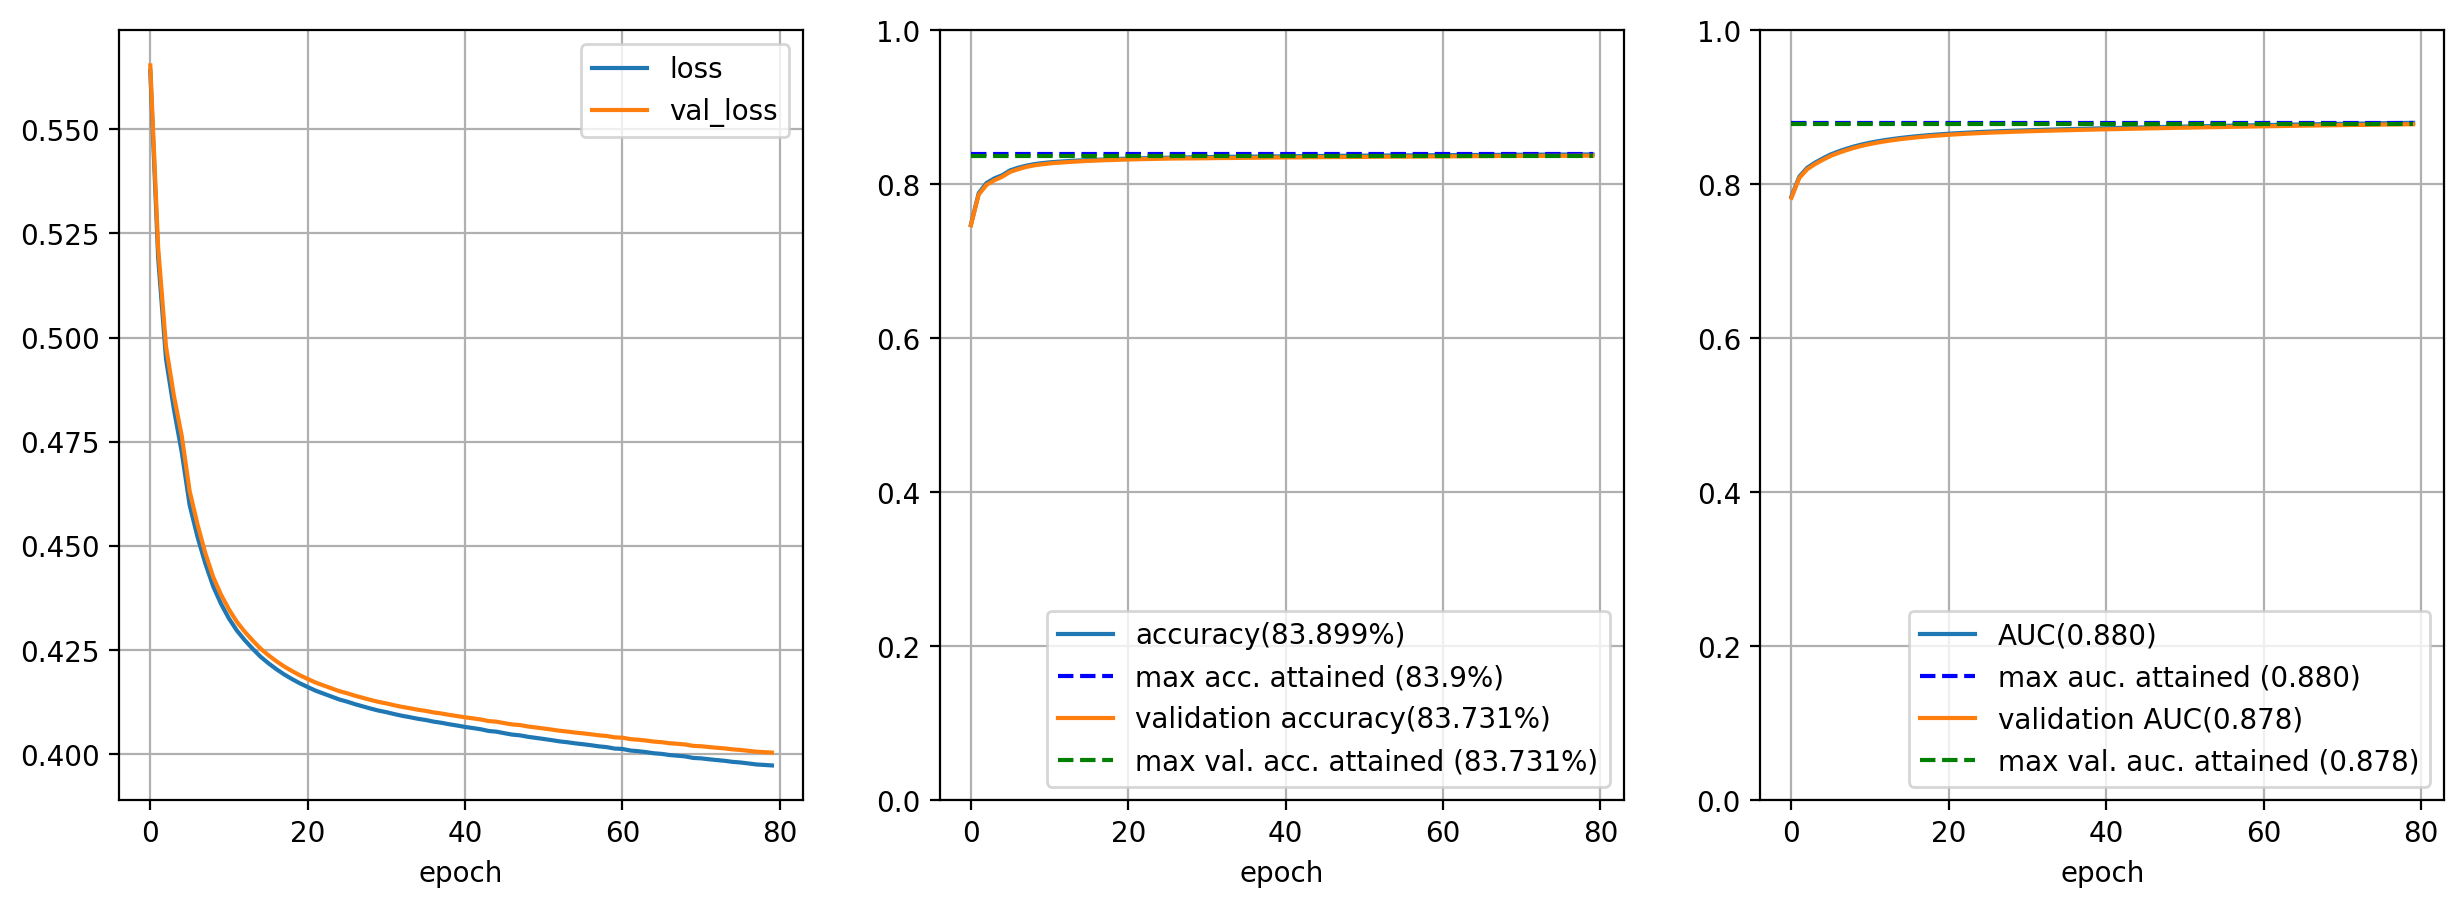

Training: Epoch [80/80] --- Loss: 0.3973 --- Accuracy: 0.8390 --- AUC: 0.880
Test    : Epoch [80/80] --- Loss: 0.4004 --- Accuracy: 0.8373 --- AUC: 0.878


In [21]:
######################################################## Track Training #############################################################

n_epochs  = 80

train_losses = []
train_accuracies = []
train_aucs = []
val_losses = []
val_accuracies = []
val_aucs = []

for i_epoch in range(n_epochs):
    

    optimizer.param_groups[0]['lr'] = learning_rate(i_epoch, initial_lr=0.001, decay_rate=0.001)  
    lr = optimizer.param_groups[0]['lr']
    print(f'learning rate was set to {lr:.5f}.')
    
    train_loop = trainloader      
    
    ############################################################ Batch Training ############################################################
    model_track.to(device)   
    model_track.train() 
    for i_batch, (train_input, train_label) in enumerate(train_loop):
        
        train_input = train_input.float().unsqueeze(0).reshape(-1, 1, input_size).to(device)
        train_label = train_label.float().to(device)
       
        optimizer.zero_grad()
    
        train_pred = model_track(train_input,key='train')
       
        loss = criterion(train_pred, train_label)
        
        if not torch.isnan(loss):
            loss.backward()
            optimizer.step()
        
    #########################################################  Evaluate metrics #########################################################
    
    print('Evaluating metrics...', end='\r')
    
    acc_metric = BinaryAccuracy()
    auc_metric = AUROC(task="binary")
    
    model_track.eval()
      
    with torch.no_grad():
        
        model_track.to('cpu')
        val_inputs = val_inputs.float().unsqueeze(0).reshape(-1, 1, input_size).cpu()
        val_labels = val_labels.reshape(-1,1).float().cpu()
        
        train_inputs = train_inputs.float().unsqueeze(0).reshape(-1, 1, input_size).cpu()
        train_labels = train_labels.reshape(-1,1).float().cpu()
        
        train_preds = model_track(train_inputs,key='train')
        val_preds  = model_track(val_inputs,key='train')
       
        train_loss = criterion(train_preds, train_labels)
        val_loss  = criterion(val_preds, val_labels)
        
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
        train_accuracy = acc_metric(train_preds, train_labels)
        val_accuracy = acc_metric(val_preds, val_labels)
        
        train_accuracies.append(train_accuracy.item())
        val_accuracies.append(val_accuracy.item())
        
        train_auc = auc_metric(train_preds, train_labels)
        val_auc = auc_metric(val_preds, val_labels)
        
        train_aucs.append(train_auc.item())
        val_aucs.append(val_auc.item())
       
    plot_metrics(np.arange(i_epoch+1), train_losses, val_losses, train_accuracies, val_accuracies, train_aucs, val_aucs)
        
    print('Evaluating metrics finished!', end='\r')  
    print(f'Training: Epoch [{i_epoch+1}/{n_epochs}] --- Loss: {train_losses[-1]:.4f} --- Accuracy: {train_accuracies[-1]:.4f} --- AUC: {train_aucs[-1]:.3f}\nTest    : Epoch [{i_epoch+1}/{n_epochs}] --- Loss: {val_losses[-1]:.4f} --- Accuracy: {val_accuracies[-1]:.4f} --- AUC: {val_aucs[-1]:.3f}\n', end='\r')

In [22]:
######################################################## Combined Pre-Processing #############################################################
train_inputs, val_inputs, train_labels, val_labels = train_test_split(orj_inputs, labels, stratify = labels, test_size = 0.2, shuffle = True, random_state = 42)

del orj_inputs, labels
gc.collect()

scaler = StandardScaler()
train_inputs = scaler.fit_transform(train_inputs)
val_inputs  = scaler.transform(val_inputs)

pca_decomposition = PCA()
train_inputs = pca_decomposition.fit_transform(train_inputs)
val_inputs   = pca_decomposition.transform(val_inputs)

train_inputs = torch.tensor(train_inputs,  dtype=torch.float32, device = 'cpu')
train_labels = torch.tensor(train_labels.to_numpy(),  dtype=torch.float32, device = 'cpu').reshape(-1, 1)

val_inputs  = torch.tensor(val_inputs,  dtype=torch.float32, device = device)
val_labels  = torch.tensor(val_labels.to_numpy(),  dtype=torch.float32, device = device).reshape(-1, 1)

batchsize   = int(len(train_inputs)/10)
trainloader = DataLoader(list(zip(train_inputs, train_labels)), batch_size = batchsize , drop_last=True )

finish = time()

print(f'Data preparation has taken {finish-start:.1f} seconds for {len(train_inputs)+len(val_inputs)} rows.')

Data preparation has taken 490.5 seconds for 930889 rows.


In [23]:
######################################################### Model constrcution #########################################################

print('Building model...', end='\r')
input_size  = 64     # change by hand
output_size = 1
#model = NeuralNetwork(input_size, output_size, nnode=32)
model_combining = NeuralNetwork_Adjustable(input_size, output_size, n_hidden_layers = 2, nnodes=32)
count_parameters(model_combining)

##################################################### Loss and Optimizer Settings #####################################################

def learning_rate(i_epoch, initial_lr = 0.01, decay_rate = 0.01):
    return initial_lr * (1-decay_rate)**i_epoch

criterion = nn.BCELoss()
params_to_optimize = [
    {'params': model_combining.parameters()},
    {'params': model.parameters()},
    {'params': model_track.parameters()}
]       
optimizer = torch.optim.RMSprop(params_to_optimize)

+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
| hidden_layers.0.weight |    1024    |
|  hidden_layers.0.bias  |     32     |
| hidden_layers.1.weight |    1024    |
|  hidden_layers.1.bias  |     32     |
|     layer1.weight      |    2048    |
|      layer1.bias       |     32     |
|    layerfin.weight     |     32     |
|     layerfin.bias      |     1      |
+------------------------+------------+
Total Trainable Params: 4225


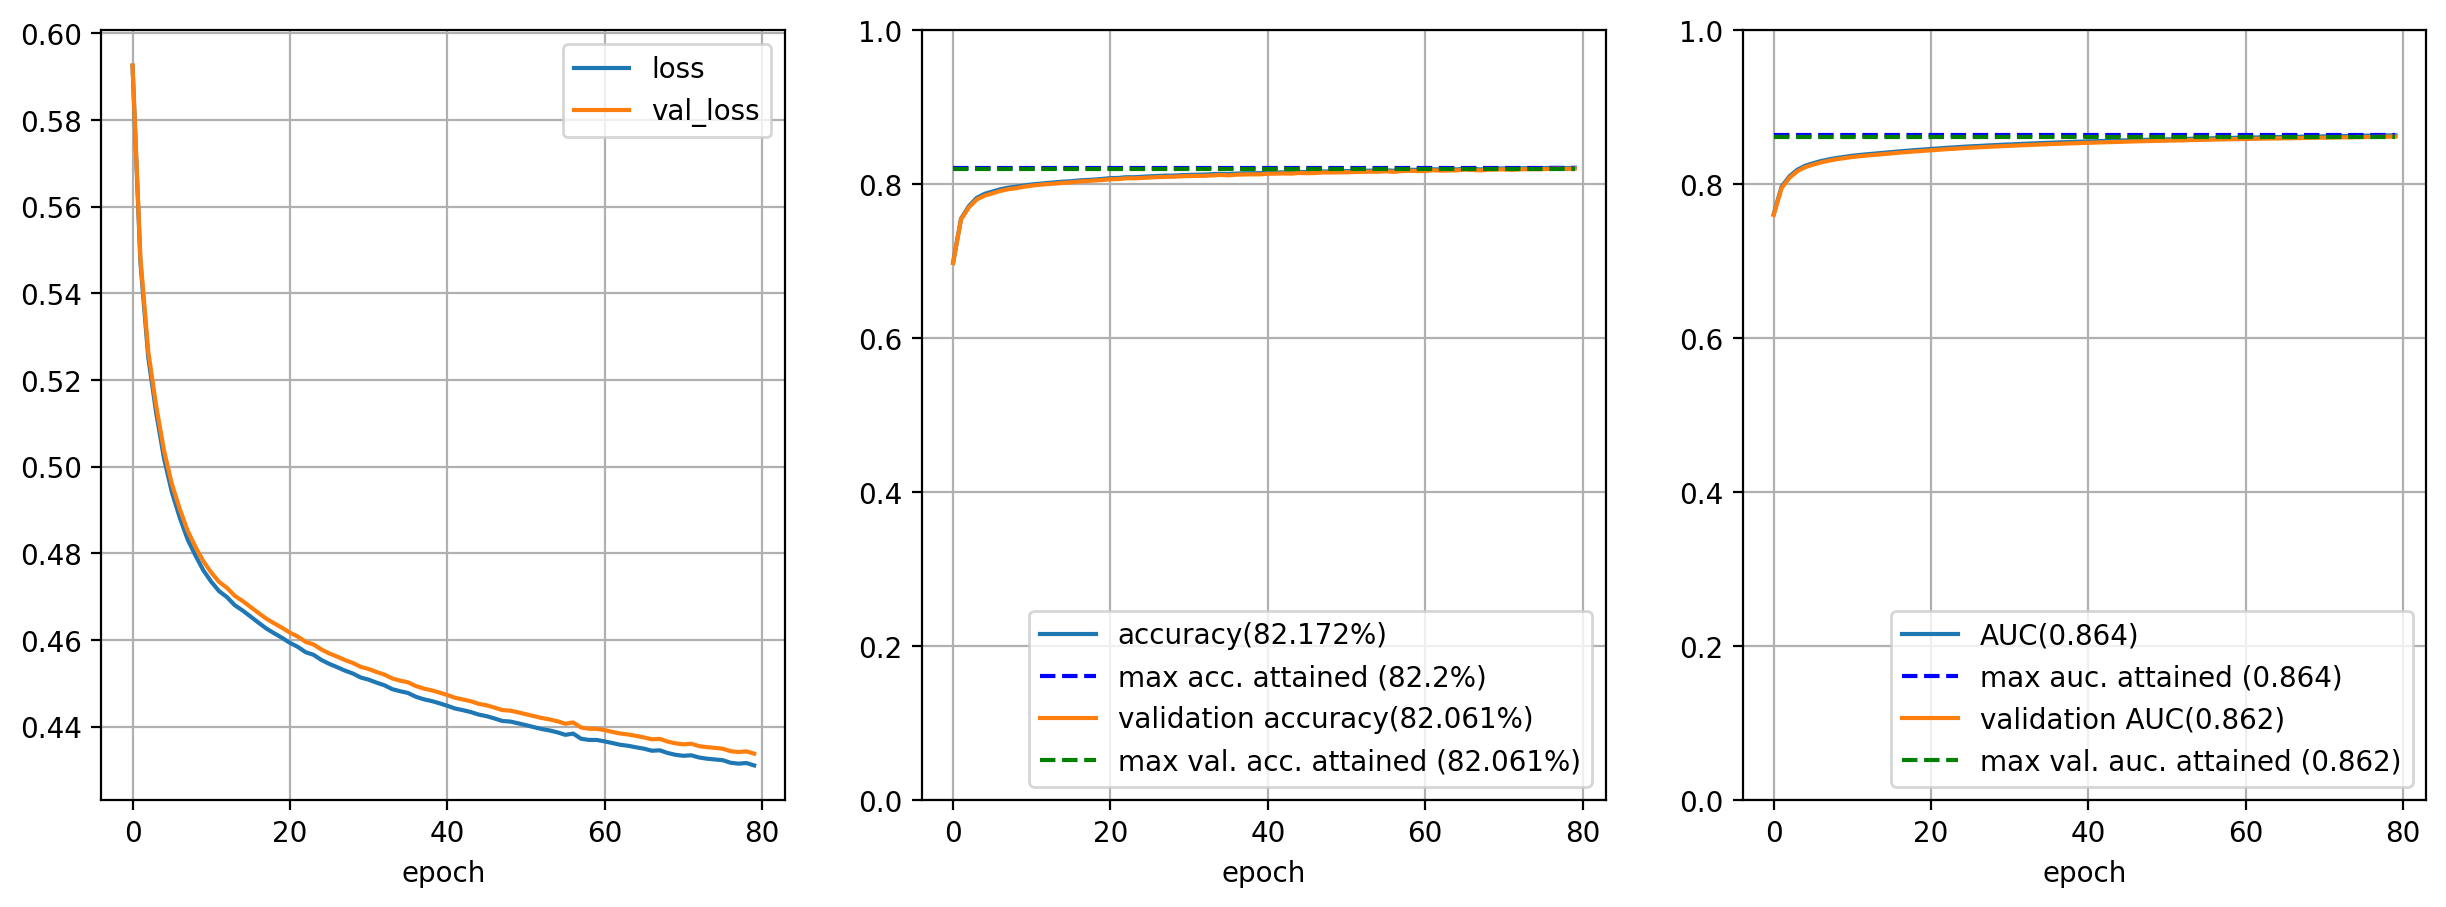

Training: Epoch [80/80] --- Loss: 0.4311 --- Accuracy: 0.8217 --- AUC: 0.864
Test    : Epoch [80/80] --- Loss: 0.4338 --- Accuracy: 0.8206 --- AUC: 0.862


In [24]:
################################################## Combined Training ##################################################
n_epochs = 80

train_losses = []
train_accuracies = []
train_aucs = []
val_losses = []
val_accuracies = []
val_aucs = []

for i_epoch in range(n_epochs):
    
    optimizer.param_groups[0]['lr'] = learning_rate(i_epoch, initial_lr=0.001, decay_rate=0.01)
    lr = optimizer.param_groups[0]['lr']
    print(f'Learning rate was set to {lr:.5f}.')
    
    train_loop = trainloader
    
    ######################################################### Batch Training #########################################################
    model_combining.to(device)
    model.to(device)  
    model_track.to(device)
    model_combining.train()
    model_track.train() # 
    model.train()  #
    
    for i_batch, (train_input, train_label) in enumerate(train_loop):
        
        train_input = train_input.float().to(device)
        train_label = train_label.reshape(-1, 1).float().to(device) 
        optimizer.zero_grad()
       
        high_level_input = train_input[:, :17]
        track_input = train_input[:, 17:].unsqueeze(0).transpose(0,1)
       
        with torch.no_grad():
            train_pred_high_level = model(high_level_input) 
            train_pred_track = model_track(track_input)  
        
       
        train_pred_combined = torch.cat((train_pred_high_level, train_pred_track), dim=1)
        train_pred_combined = model_combining(train_pred_combined)
      
        loss = criterion(train_pred_combined, train_label)
        
        if not torch.isnan(loss):
            loss.backward()
            optimizer.step()
        
    ######################################################## Evaluate metrics ########################################################
    
    print('Evaluating metrics...', end='\r')
    
    acc_metric = BinaryAccuracy()
    auc_metric = AUROC(task="binary")
    
    model_combining.eval()
    model_track.eval()
    model.eval()  
        
    with torch.no_grad():
        
        model_combining.to('cpu')
        model_track.to('cpu')
        model.to('cpu') 

        train_inputs = train_inputs.float().cpu()
        train_labels = train_labels.reshape(-1,1).float().cpu()
       
        val_inputs = val_inputs.float().cpu()
        val_labels = val_labels.reshape(-1,1).float().cpu()
        
        train_high_level_input = train_inputs[:, :17]
        train_track_input = train_inputs[:, 17:].unsqueeze(0).transpose(0,1)
    
        val_high_level_input = val_inputs[:, :17]
        val_track_input = val_inputs[:, 17:].unsqueeze(0).transpose(0,1)
        
        with torch.no_grad():
            train_preds_high_level = model(train_high_level_input)  
            train_preds_track = model_track(train_track_input)   
           
            val_preds_high_level = model(val_high_level_input)  
            val_preds_track = model_track(val_track_input)  
        
        val_preds = torch.cat((val_preds_high_level, val_preds_track), dim=1)
        train_preds= torch.cat((train_preds_high_level, train_preds_track), dim=1)
        
        val_preds = model_combining(val_preds)
        train_preds = model_combining(train_preds)

        train_loss = criterion(train_preds, train_labels)
        val_loss = criterion(val_preds, val_labels)
        
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
        train_accuracy = acc_metric(train_preds, train_labels)
        val_accuracy = acc_metric(val_preds, val_labels)
        
        train_accuracies.append(train_accuracy.item())
        val_accuracies.append(val_accuracy.item())
        
        train_auc = auc_metric(train_preds, train_labels)
        val_auc = auc_metric(val_preds, val_labels)
        
        train_aucs.append(train_auc.item())
        val_aucs.append(val_auc.item())
    
    plot_metrics(np.arange(i_epoch+1), train_losses, val_losses, train_accuracies, val_accuracies, train_aucs, val_aucs)
        
     
    print('Evaluating metrics finished!', end='\r')  
    print(f'Training: Epoch [{i_epoch+1}/{n_epochs}] --- Loss: {train_losses[-1]:.4f} --- Accuracy: {train_accuracies[-1]:.4f} --- AUC: {train_aucs[-1]:.3f}\nTest    : Epoch [{i_epoch+1}/{n_epochs}] --- Loss: {val_losses[-1]:.4f} --- Accuracy: {val_accuracies[-1]:.4f} --- AUC: {val_aucs[-1]:.3f}\n', end='\r')
